In [ ]:
import os
import random
import numpy as np
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
dataset_folder = r'C:/Users/user/Downloads/Thesis/linda_trials/linda_trials/JAFFE Dataset'

# Function to load images and extract labels
def load_images_and_labels(folder):
    images = []
    labels = []
    label_map = {
        "AN": "anger",
        "DI": "disgust",
        "FE": "fear",
        "HA": "happiness",
        "SA": "sadness",
        "SU": "surprise",
        "NE": "neutral"
    }

    for filename in os.listdir(folder):
        if filename.endswith('.tiff'):
            image_file = os.path.join(folder, filename)
            img = Image.open(image_file).convert('L')  # Convert to grayscale
            img = img.resize((64, 64))  # Resize to 64x64 for consistency
            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
            label_code = filename.split('.')[1][:2]
            labels.append(label_map[label_code])

    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Display a few sample images with their labels
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].reshape(64, 64), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
plt.show()

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)


# Define the CNN architecture function
def create_model():
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
        Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
        Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Second convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # Second pooling layer
        Flatten(),  # Flatten the output for the dense layer
        Dense(100, activation='relu'),  # Fully connected layer
        Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize list to store results
results = []

# No data augmentation configuration
config = {
    "shear_range": 0.0,
    "zoom_range": 0.0,
    "rotation_range": 0,
    "width_shift_range": 0.0,
    "height_shift_range": 0.0,
    "horizontal_flip": False
}

print(f"Running configuration: No Data Augmentation")

# Create the model
model = create_model()

# Define data augmentation configuration (with no augmentation)
datagen = ImageDataGenerator(
    shear_range=config["shear_range"],
    zoom_range=config["zoom_range"],
    rotation_range=config["rotation_range"],
    width_shift_range=config["width_shift_range"],
    height_shift_range=config["height_shift_range"],
    horizontal_flip=config["horizontal_flip"]
)

# Fit the data generator to the training data
datagen.fit(X_train)

# Train the model using class weights and the data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, seed=42),
    validation_data=(X_test, y_test),
    epochs=20,
    verbose=1  # Suppress epoch prints
)

# Evaluate the model and store the results
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

precision = tf.keras.metrics.Precision()
precision.update_state(true_classes, predicted_classes)
recall = tf.keras.metrics.Recall()
recall.update_state(true_classes, predicted_classes)
f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

# Plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Store the configuration and results
config_results = {
    'config': 'No Data Augmentation',
    'test_accuracy': test_acc,
    'precision': precision.result().numpy(),
    'recall': recall.result().numpy(),
    'f1_score': f1_score
}

# Print the results for this configuration
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision.result().numpy():.2f}")
print(f"Recall: {recall.result().numpy():.2f}")
print(f"F1 Score: {f1_score:.2f}")
print("="*50)

results.append(config_results)

print("\nSummary of Results:")
for idx, result in enumerate(results):
    print(f"Configuration {idx+1}: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")
    print("="*50)

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


training the CNN on the JAFFE dataset:

### **Dataset Preprocessing:**
- **Images**: Loaded from a specified folder, converted to grayscale, resized to 64x64 pixels, and normalized to [0, 1].
- **Label Mapping**: Labels are mapped from filename codes (e.g., "AN" for anger, "HA" for happiness) to their corresponding emotions.
- **Reshaping**: Images reshaped to `(64, 64, 1)` for compatibility with the CNN input.
- **Label Encoding**: Labels are encoded using `LabelEncoder` and converted to one-hot encoding.

### **Data Splitting:**
- **Train/Test Split**: The dataset is split into 80% training and 20% testing.

### **CNN Architecture:**
1. **Input Layer**: Accepts input of shape `(64, 64, 1)` for grayscale images.
    2. **First Conv2D Layer**: 32 filters, `(3x3)` kernel size, ReLU activation.
3. **First MaxPooling2D Layer**: `(2x2)` pool size to reduce spatial dimensions.
4. **Second Conv2D Layer**: 64 filters, `(3x3)` kernel size, ReLU activation.
5. **Second MaxPooling2D Layer**: `(2x2)` pool size.
6. **Flatten Layer**: Converts 2D feature maps into a 1D vector.
7. **Dense Layer**: 100 units with ReLU activation.
8. **Output Layer**: Softmax activation with a number of neurons equal to the number of emotion classes.

### **Model Compilation:**
- **Optimizer**: Adam.
- **Loss Function**: Categorical cross-entropy.
- **Metrics**: Accuracy.

### **Data Augmentation:**
- **Configuration**: No data augmentation applied (`horizontal_flip=False` and other augmentation parameters set to 0).

### **Model Training:**
- **Epochs**: 20.
- **Batch Size**: 32.
- **Training**: The model is trained using the `ImageDataGenerator` without data augmentation.

### **Evaluation Metrics:**
- **Test Accuracy**: Evaluated on the test set.
- **Precision, Recall, F1 Score**: Calculated to provide detailed performance metrics.
- **Confusion Matrix**: Generated to visualize classification performance.

### **Visualization:**
- **Confusion Matrix**: Displayed using a heatmap to show true vs. predicted labels.
- **Accuracy and Loss Plots**: Training and validation accuracy/loss are plotted over the epochs.

### **Results Summary:**
- **Test Accuracy**: Reflects the overall correctness of predictions.
- **Precision, Recall, F1 Score**: Provide deeper insights into how well the model handles each class.
    - **Confusion Matrix**: Helps identify which classes are most frequently confused.

This setup is straightforward, focusing on a basic CNN architecture with no data augmentation applied, suitable for initial experiments on the JAFFE dataset.

In [ ]:
#data aug jafee

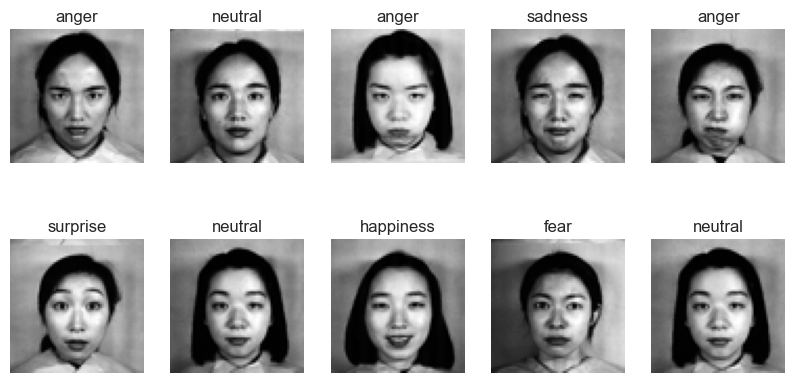

Label distribution:
anger: 30 images
neutral: 30 images
sadness: 31 images
surprise: 30 images
happiness: 31 images
fear: 32 images
disgust: 29 images
Running configuration 1/12: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Configuration 1: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 76.74%
Precision: 0.97
Recall: 1.00
F1 Score: 0.99
Running configuration 2/12: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Configuration 2: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 81.40%
Precision: 1.00
Recall: 0.97
F1 Score: 0.99
Running configuration 3/12: {'shear_range': 0.0, 'zoom_range': 0.

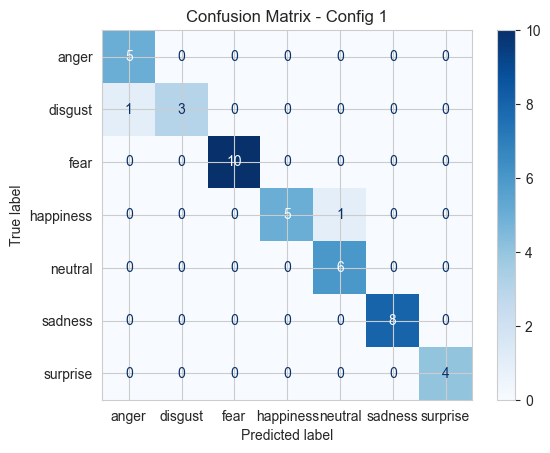

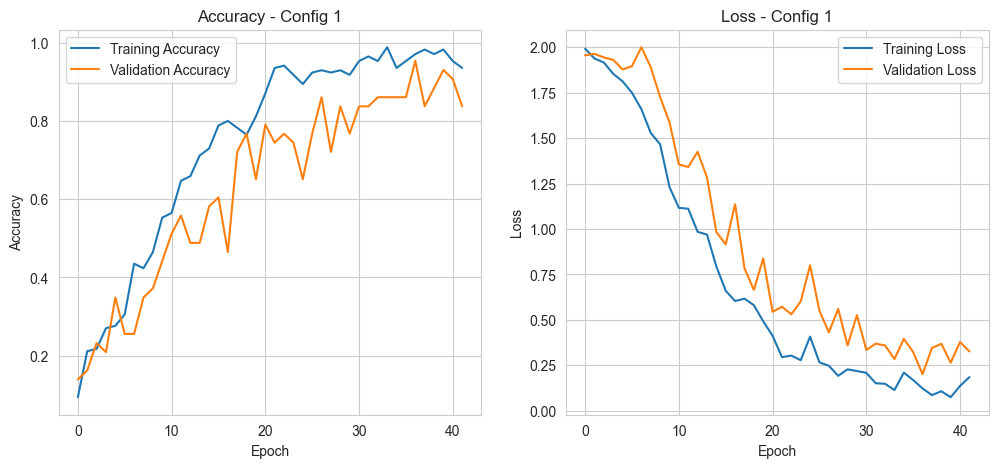


Top 2 Configuration: {'shear_range': 0.2, 'zoom_range': 0.1, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 93.02%
Precision: 0.95
Recall: 0.97
F1 Score: 0.96


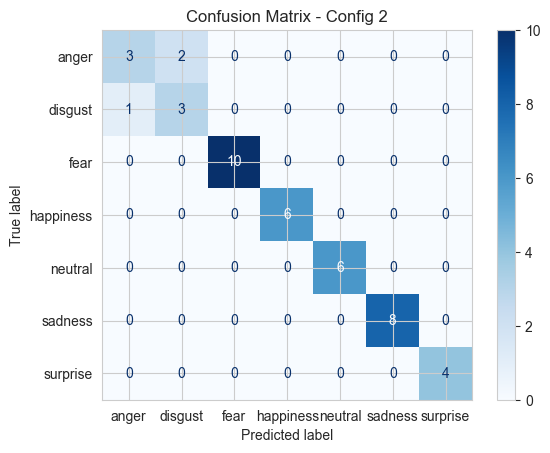

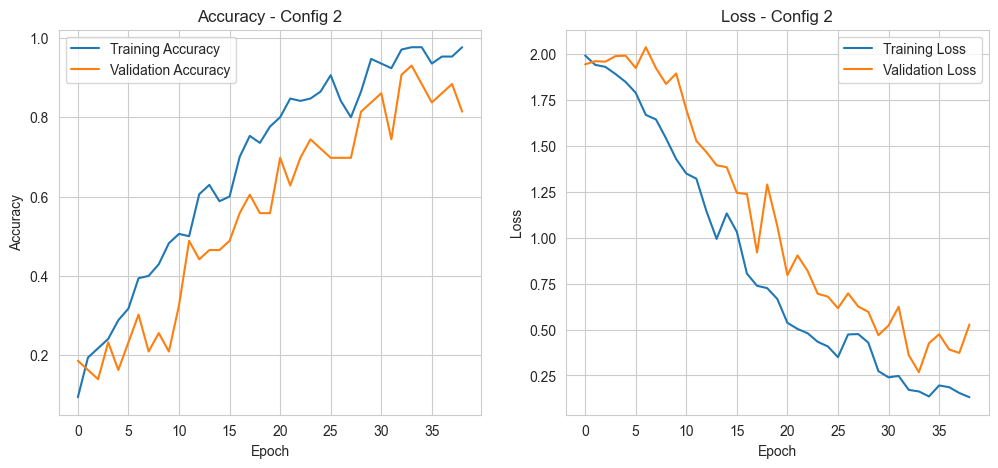


Top 3 Configuration: {'shear_range': 0.2, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 83.72%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


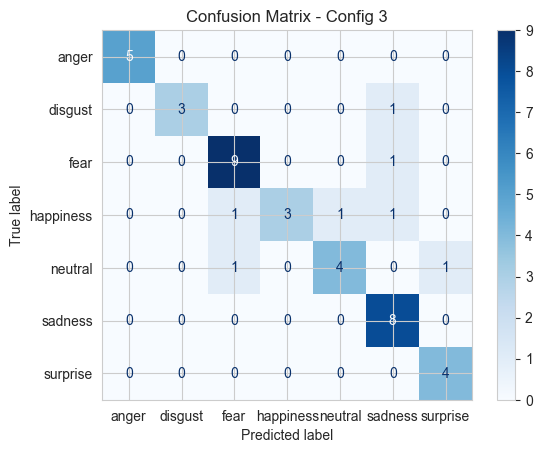

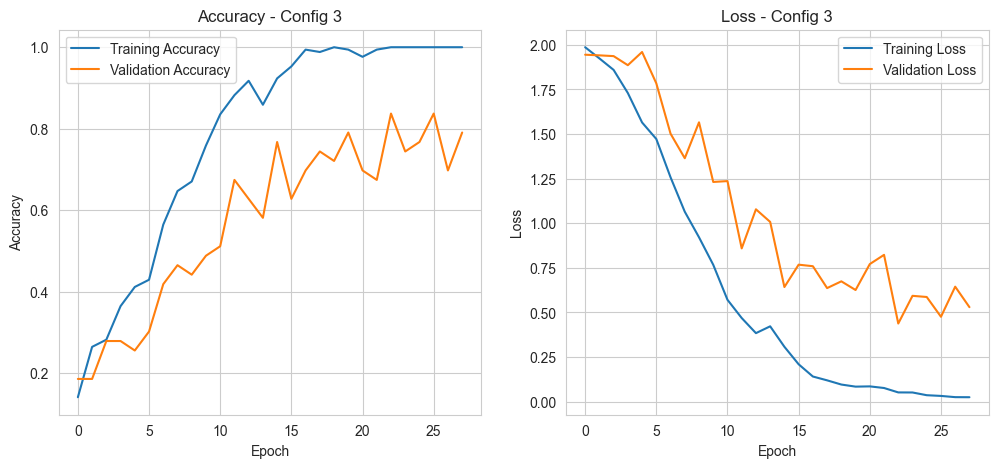


Top 4 Configuration: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 81.40%
Precision: 1.00
Recall: 0.97
F1 Score: 0.99


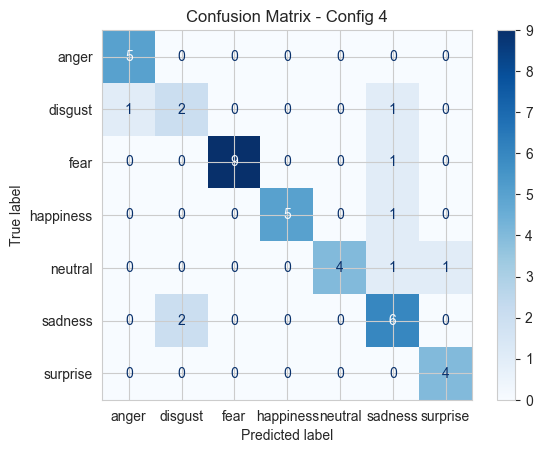

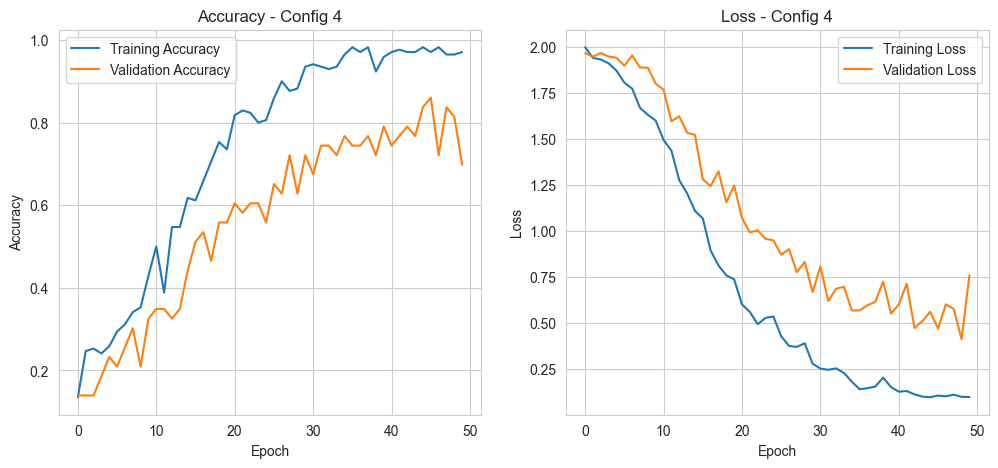


Top 5 Configuration: {'shear_range': 0.0, 'zoom_range': 0.2, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 81.40%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97


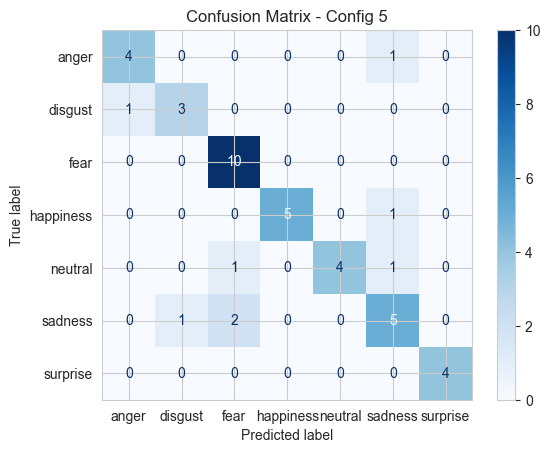

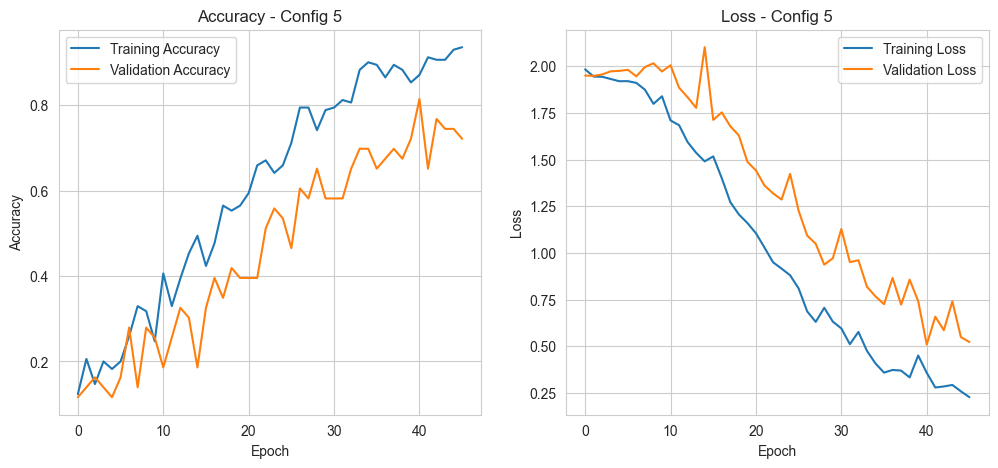


Top 6 Configuration: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 76.74%
Precision: 0.97
Recall: 1.00
F1 Score: 0.99


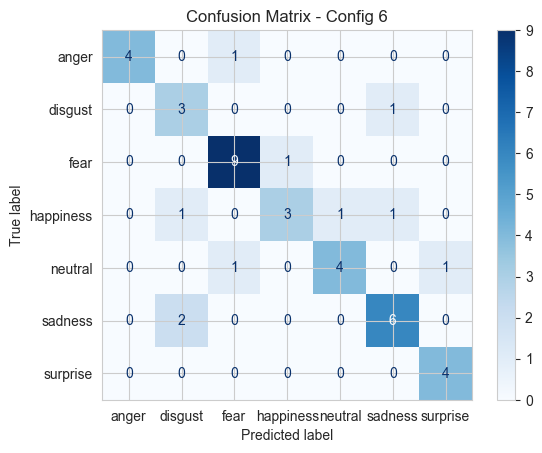

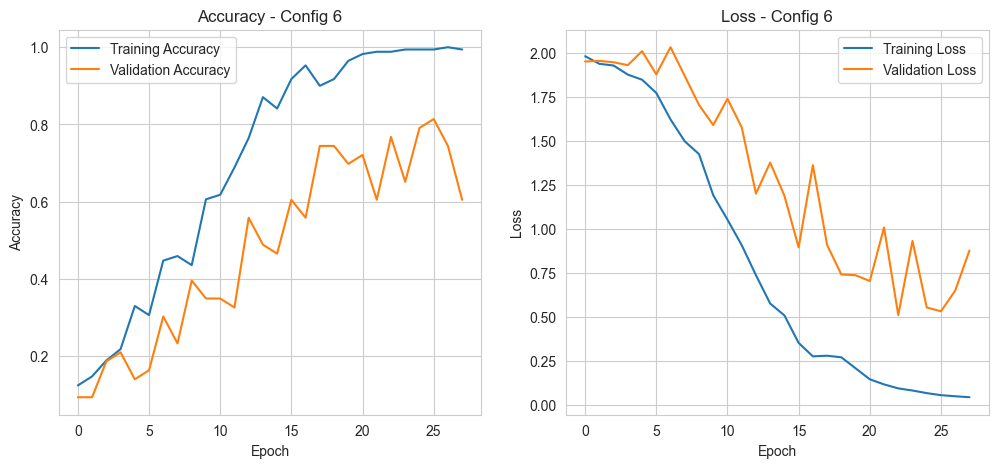


Top 7 Configuration: {'shear_range': 0.0, 'zoom_range': 0.1, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 20.93%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94


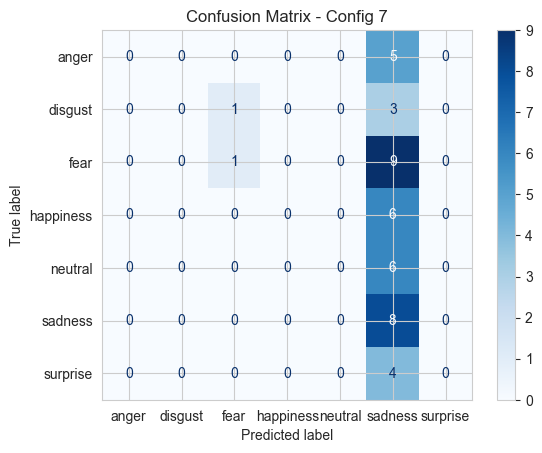

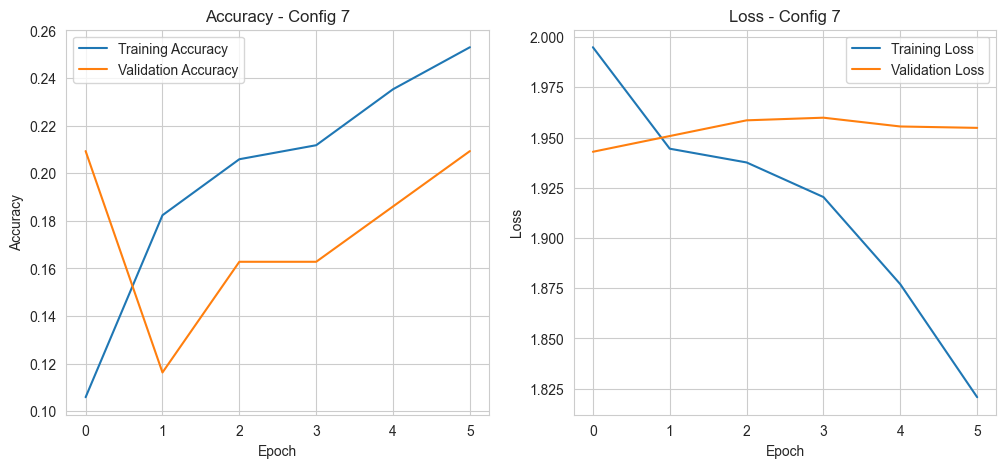


Top 8 Configuration: {'shear_range': 0.2, 'zoom_range': 0.2, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 20.93%
Precision: 0.94
Recall: 0.76
F1 Score: 0.84


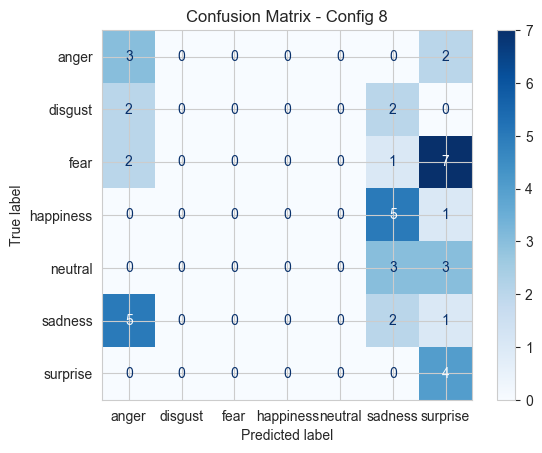

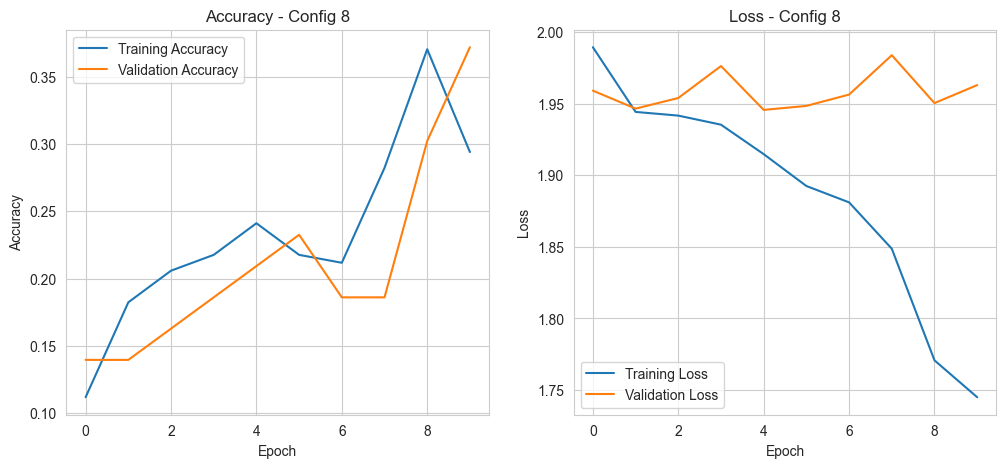


Top 9 Configuration: {'shear_range': 0.0, 'zoom_range': 0.2, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 16.28%
Precision: 0.92
Recall: 0.63
F1 Score: 0.75


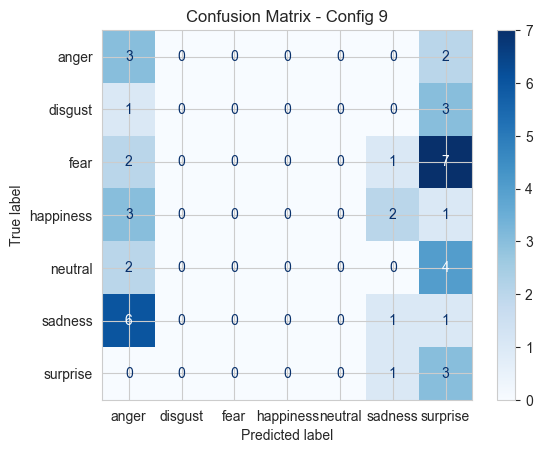

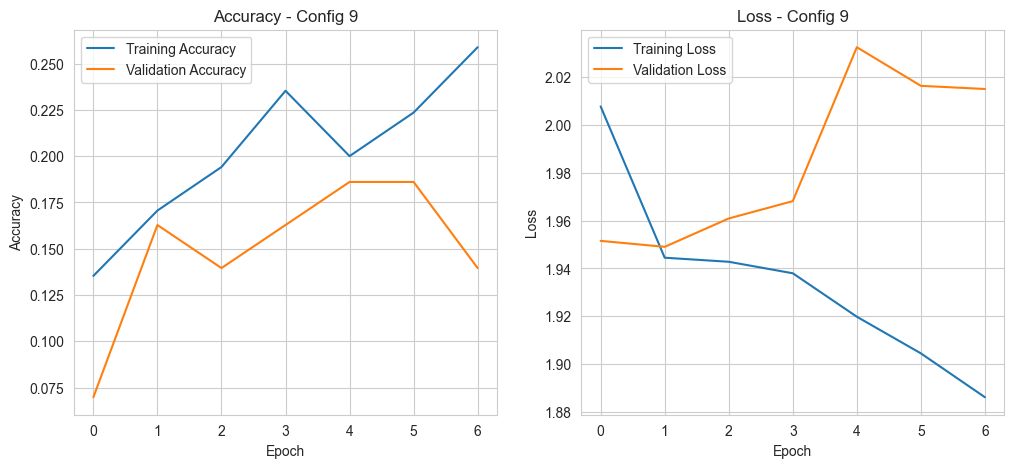


Top 10 Configuration: {'shear_range': 0.2, 'zoom_range': 0.1, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 16.28%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94


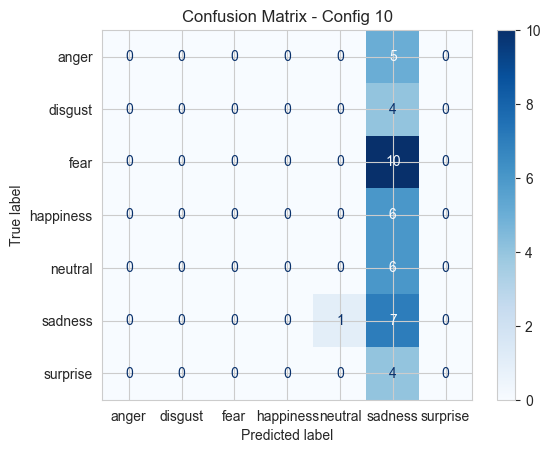

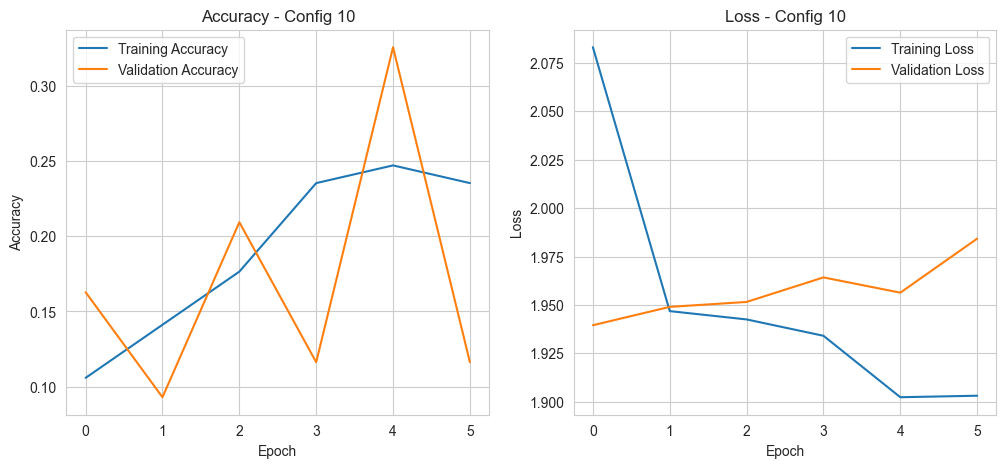


Top 11 Configuration: {'shear_range': 0.2, 'zoom_range': 0.0, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 9.30%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94


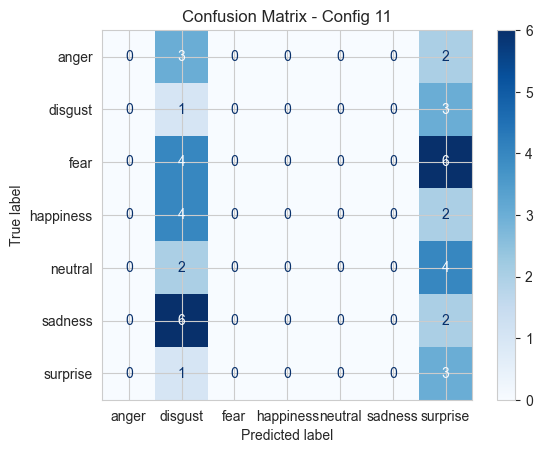

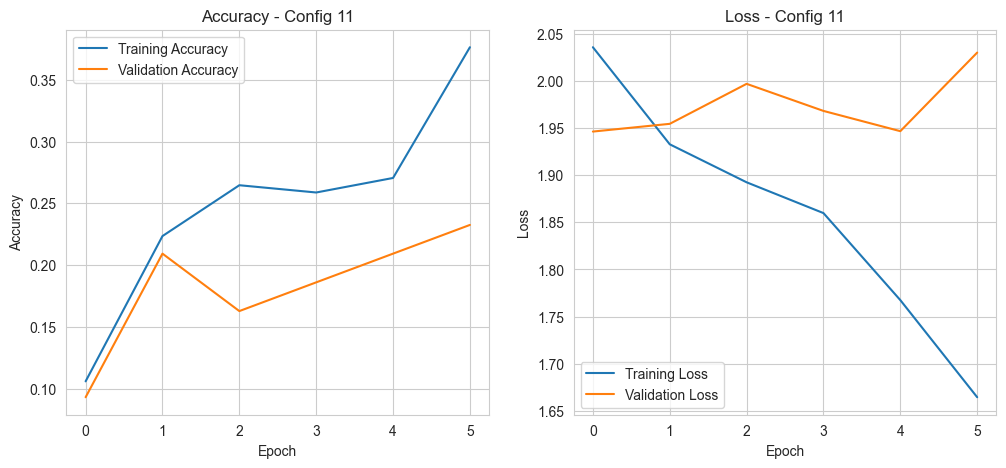


Top 12 Configuration: {'shear_range': 0.2, 'zoom_range': 0.2, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 9.30%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94


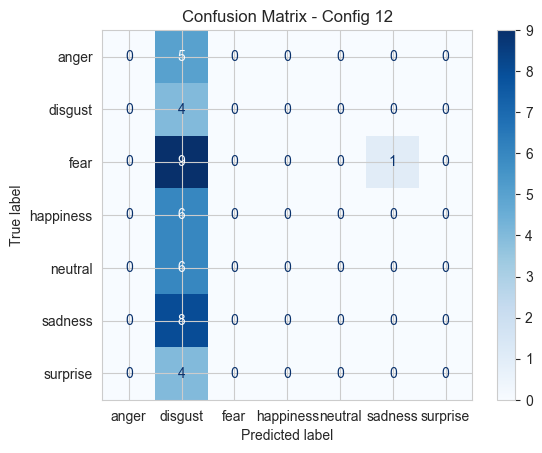

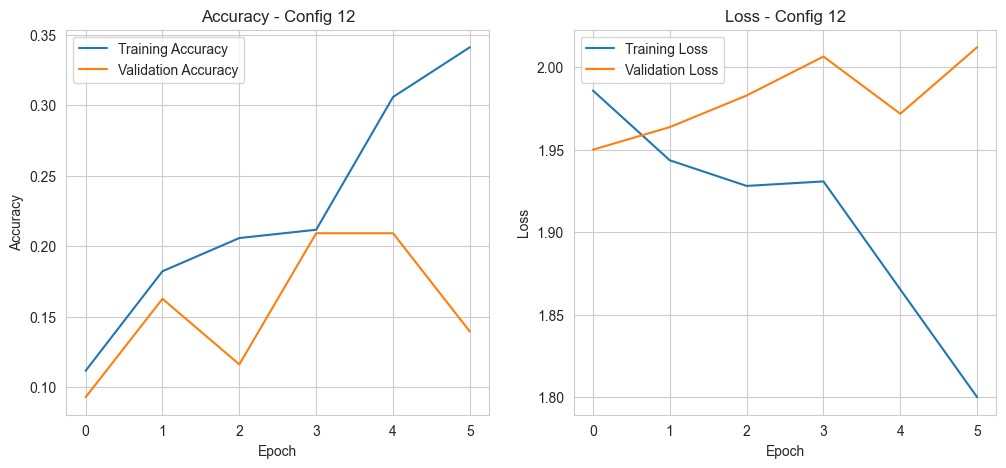


Summary of Top 15 Configurations:
Configuration 1: {'shear_range': 0.0, 'zoom_range': 0.1, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 95.35%
Precision: 1.00
Recall: 0.97
F1 Score: 0.99
Configuration 2: {'shear_range': 0.2, 'zoom_range': 0.1, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 93.02%
Precision: 0.95
Recall: 0.97
F1 Score: 0.96
Configuration 3: {'shear_range': 0.2, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 83.72%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Configuration 4: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 81.40%
Precision: 1.00
Recall: 0.97
F1 Score: 0.99
Configuration 5: {'shear_range': 0.0, 'zoom_range': 0.2, 'rotation_range

In [22]:
import itertools
import os
import random
import numpy as np
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
dataset_folder = r'C:/Users/user/Downloads/Thesis/linda_trials/JAFFE Dataset'

# Function to load images and extract labels
def load_images_and_labels(folder):
    images = []
    labels = []
    label_map = {
        "AN": "anger",
        "DI": "disgust",
        "FE": "fear",
        "HA": "happiness",
        "SA": "sadness",
        "SU": "surprise",
        "NE": "neutral"
    }

    for filename in os.listdir(folder):
        if filename.endswith('.tiff'):
            image_file = os.path.join(folder, filename)
            img = Image.open(image_file).convert('L')  # Convert to grayscale
            img = img.resize((64, 64))  # Resize to 64x64 for consistency
            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
            label_code = filename.split('.')[1][:2]
            labels.append(label_map[label_code])

    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Display a few sample images with their labels
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].reshape(64, 64), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
plt.show()

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)


# Define the CNN architecture function
def create_model():
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
        Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
        Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Second convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # Second pooling layer
        Flatten(),  # Flatten the output for the dense layer
        Dense(100, activation='relu'),  # Fully connected layer
        Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize list to store results
results = []

# Define parameter ranges for data augmentation
shear_range_values = [0.0, 0.2]
zoom_range_values = [0.0, 0.1, 0.2]
rotation_range_values = [0, 10 ]
width_shift_range_values = [0.0 ]
height_shift_range_values = [0.0 ]
horizontal_flip_values = [ False]

# Generate all combinations of parameters
param_combinations = list(itertools.product(shear_range_values, zoom_range_values, rotation_range_values,
                                            width_shift_range_values, height_shift_range_values, horizontal_flip_values))

# Loop through each combination
for idx, (shear_range, zoom_range, rotation_range, width_shift_range, height_shift_range, horizontal_flip) in enumerate(param_combinations):
    config = {
        "shear_range": shear_range,
        "zoom_range": zoom_range,
        "rotation_range": rotation_range,
        "width_shift_range": width_shift_range,
        "height_shift_range": height_shift_range,
        "horizontal_flip": horizontal_flip
    }

    print(f"Running configuration {idx+1}/{len(param_combinations)}: {config}")

    # Create the model
    model = create_model()

    # Define data augmentation configuration
    datagen = ImageDataGenerator(
        shear_range=config["shear_range"],
        zoom_range=config["zoom_range"],
        rotation_range=config["rotation_range"],
        width_shift_range=config["width_shift_range"],
        height_shift_range=config["height_shift_range"],
        horizontal_flip=config["horizontal_flip"]
    )

    # Fit the data generator to the training data
    datagen.fit(X_train)

    # Add early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model using class weights and the data generator
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=16, seed=42),
        validation_data=(X_test, y_test),
        epochs=50,
        callbacks=[early_stopping],  # Add early stopping
        verbose=0  # Suppress epoch prints
    )

    # Evaluate the model and store the results
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    predictions = model.predict(X_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    precision = tf.keras.metrics.Precision()
    precision.update_state(true_classes, predicted_classes)
    recall = tf.keras.metrics.Recall()
    recall.update_state(true_classes, predicted_classes)
    f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

    # Store the configuration and results
    config_results = {
        'config': config,
        'test_accuracy': test_acc,
        'precision': precision.result().numpy(),
        'recall': recall.result().numpy(),
        'f1_score': f1_score,
        'history': history.history,
        'confusion_matrix': confusion_matrix(true_classes, predicted_classes),
        'labels': label_encoder.classes_
    }
    print(f"Configuration {idx+1}: {config_results['config']}")
    print(f"Test Accuracy: {config_results['test_accuracy']*100:.2f}%")
    print(f"Precision: {config_results['precision']:.2f}")
    print(f"Recall: {config_results['recall']:.2f}")
    print(f"F1 Score: {config_results['f1_score']:.2f}")
    print("="*50)

    results.append(config_results)

# Sort results by test accuracy and take the top 15
results_sorted = sorted(results, key=lambda x: x['test_accuracy'], reverse=True)[:15]

# Plot results for top 15 configurations
for i, result in enumerate(results_sorted):
    print(f"\nTop {i+1} Configuration: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=result['confusion_matrix'], display_labels=result['labels'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - Config {i+1}")
    plt.show()

    # Plot accuracy and loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(result['history']['accuracy'], label='Training Accuracy')
    plt.plot(result['history']['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy - Config {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(result['history']['loss'], label='Training Loss')
    plt.plot(result['history']['val_loss'], label='Validation Loss')
    plt.title(f'Loss - Config {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Summary of top 15 configurations
print("\nSummary of Top 15 Configurations:")
for i, result in enumerate(results_sorted):
    print(f"Configuration {i+1}: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")
    print("="*50)


Here's a summary of what the above code does:

### **Purpose:**
The code is designed to experiment with different configurations of data augmentation parameters on the JAFFE dataset to find the best-performing configuration for a Convolutional Neural Network (CNN) model in terms of accuracy, precision, recall, and F1 score.

### **Dataset Preprocessing:**
- **Images**: Loaded from the JAFFE dataset, converted to grayscale, resized to 64x64 pixels, and normalized to [0, 1].
- **Label Mapping**: Emotion labels are mapped from filename codes (e.g., "AN" for anger, "HA" for happiness).
- **Reshaping**: Images reshaped to `(64, 64, 1)` for CNN input.
    - **Label Encoding**: Labels are encoded using `LabelEncoder` and converted to one-hot encoding.

### **Model Architecture:**
- **CNN Model**:
1. **Input Layer**: Accepts input of shape `(64, 64, 1)`.
2. **First Conv2D Layer**: 32 filters, `(3x3)` kernel size, ReLU activation.
3. **First MaxPooling2D Layer**: Pool size `(2x2)`.
4. **Second Conv2D Layer**: 64 filters, `(3x3)` kernel size, ReLU activation.
5. **Second MaxPooling2D Layer**: Pool size `(2x2)`.
6. **Flatten Layer**: Converts 2D feature maps into a 1D vector.
7. **Dense Layer**: 100 units, ReLU activation.
8. **Output Layer**: Softmax activation with neurons equal to the number of emotion classes.
- **Model Compilation**: Uses the Adam optimizer, categorical cross-entropy loss, and accuracy as the metric.

### **Data Augmentation:**
- The code explores various combinations of data augmentation parameters:
- **Shear Range**: `[0.0, 0.2]`
- **Zoom Range**: `[0.0, 0.1, 0.2]`
- **Rotation Range**: `[0, 10]`
- **Width Shift Range**: `[0.0]`
- **Height Shift Range**: `[0.0]`
- **Horizontal Flip**: `[False]`
- **Total Combinations**: The script generates all combinations of these parameters and tests each one.

### **Training and Evaluation:**
- **Early Stopping**: Added to prevent overfitting, with monitoring on validation loss and a patience of 5 epochs.
- **Training**: The model is trained for up to 50 epochs with a batch size of 16, but training can stop early due to the EarlyStopping callback.
- **Evaluation Metrics**: Test accuracy, precision, recall, and F1 score are calculated. The confusion matrix is also computed to visualize the classification results.

### **Result Analysis:**
- **Top 15 Configurations**: The script sorts the configurations based on test accuracy and keeps the top 15.
- **Visualization**: For each of the top 15 configurations:
- **Confusion Matrix**: Displayed using a heatmap.
- **Accuracy and Loss Plots**: Training and validation accuracy/loss are plotted over the epochs.
- **Summary**: A summary of the top 15 configurations is printed, including test accuracy, precision, recall, and F1 score.

### **Conclusion:**
The code systematically tests different data augmentation strategies on a CNN model trained on the JAFFE dataset to find the most effective configuration for emotion classification. This approach allows the user to identify the augmentation settings that provide the best balance of performance metrics.

In [ ]:
#cnn opt jafee

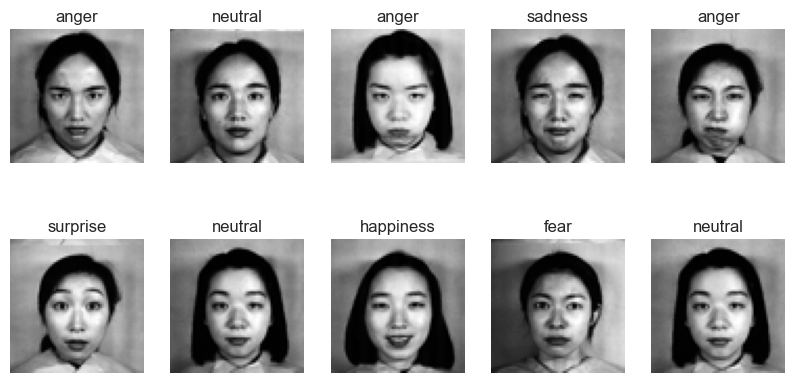

Label distribution:
anger: 30 images
neutral: 30 images
sadness: 31 images
surprise: 30 images
happiness: 31 images
fear: 32 images
disgust: 29 images
Running configuration 1/48: {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.3, 'epochs': 50, 'batch_size': 8, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Configuration 1: {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.3, 'epochs': 50, 'batch_size': 8, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 76.74%
Precision: 0.95
Recall: 0.97
F1 Score: 0.96
Running configuration 2/48: {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.3, 'epochs': 50, 'batch_size': 16, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Configuration 2: {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.3, 'epochs': 50, 'batch_size': 16, 'learning_rate

/var/folders/nt/vmygtqvs10vb28qdjwspykv00000gn/T/ipykernel_2294/382535941.py:226: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())


Configuration 37: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.3, 'epochs': 50, 'batch_size': 8, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 11.63%
Precision: 0.00
Recall: 0.00
F1 Score: nan
Running configuration 38/48: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.3, 'epochs': 50, 'batch_size': 16, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Configuration 38: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.3, 'epochs': 50, 'batch_size': 16, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 86.05%
Precision: 0.95
Recall: 1.00
F1 Score: 0.97
Running configuration 39/48: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.3, 'epochs': 50, 'batch_size': 8, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Configuration 39: {'conv_lay

/var/folders/nt/vmygtqvs10vb28qdjwspykv00000gn/T/ipykernel_2294/382535941.py:226: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())


Configuration 44: {'conv_layers': 2, 'filters': 64, 'dense_layers': 2, 'dense_units': 64, 'dropout': 0.3, 'epochs': 50, 'batch_size': 16, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 11.63%
Precision: 0.00
Recall: 0.00
F1 Score: nan
Running configuration 45/48: {'conv_layers': 2, 'filters': 64, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.3, 'epochs': 50, 'batch_size': 8, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Configuration 45: {'conv_layers': 2, 'filters': 64, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.3, 'epochs': 50, 'batch_size': 8, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 13.95%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94
Running configuration 46/48: {'conv_layers': 2, 'filters': 64, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.3, 'epochs': 50, 'batch_size': 16, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Configuration 46: {'conv_l

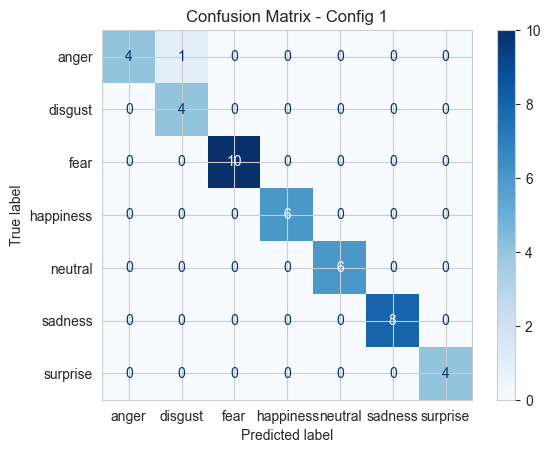

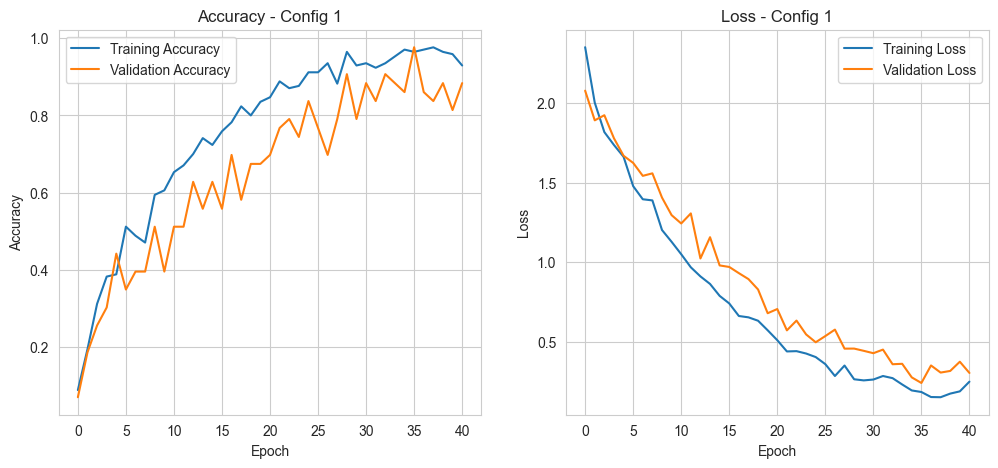


Top 2 Configuration: {'conv_layers': 1, 'filters': 32, 'dense_layers': 2, 'dense_units': 256, 'dropout': 0.3, 'epochs': 50, 'batch_size': 8, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 97.67%
Precision: 0.97
Recall: 1.00
F1 Score: 0.99


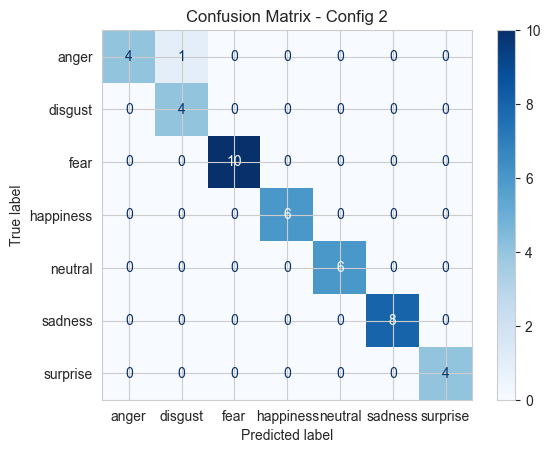

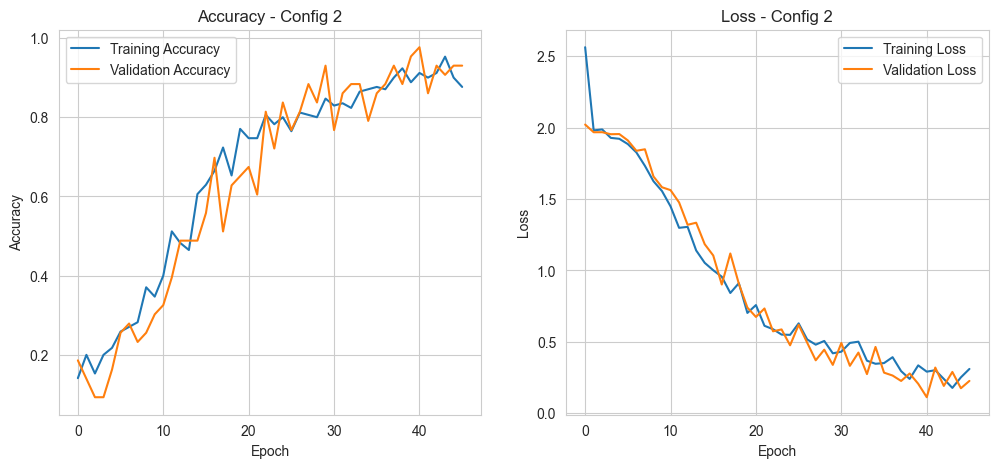


Top 3 Configuration: {'conv_layers': 1, 'filters': 64, 'dense_layers': 1, 'dense_units': 256, 'dropout': 0.3, 'epochs': 50, 'batch_size': 16, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 95.35%
Precision: 1.00
Recall: 0.97
F1 Score: 0.99


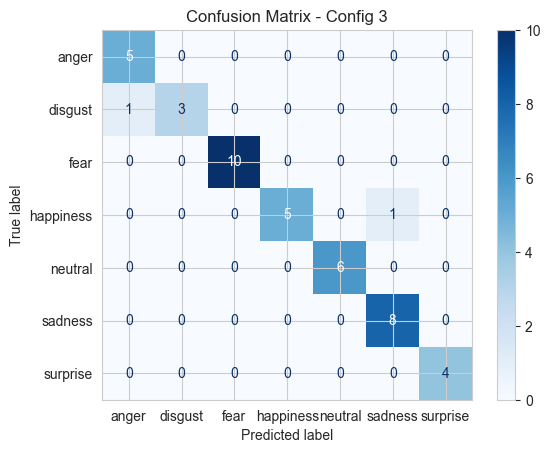

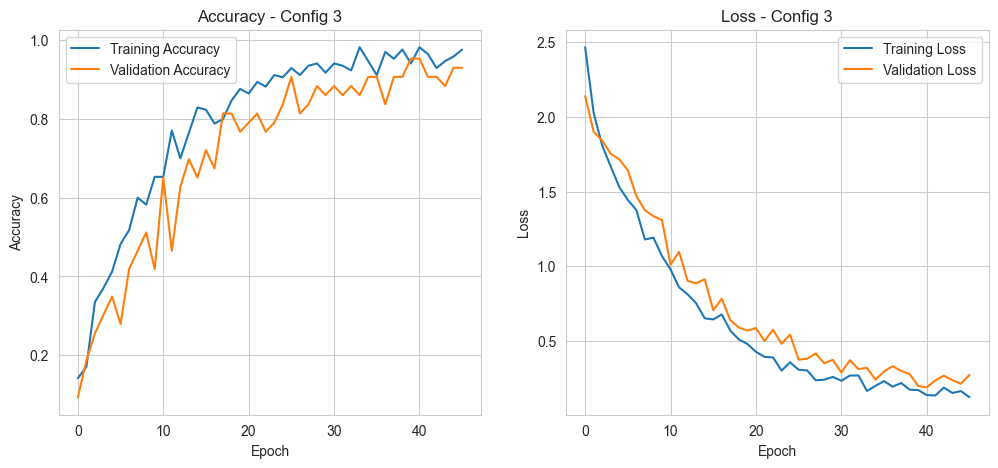


Top 4 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.3, 'epochs': 50, 'batch_size': 16, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 95.35%
Precision: 0.95
Recall: 1.00
F1 Score: 0.97


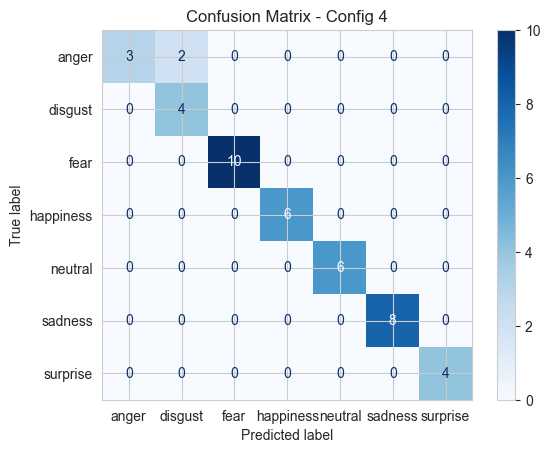

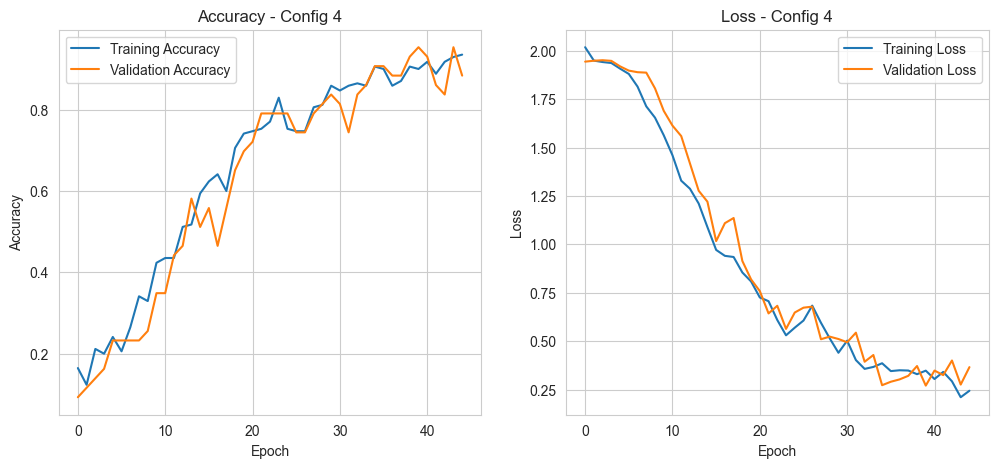


Top 5 Configuration: {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.3, 'epochs': 50, 'batch_size': 16, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 93.02%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97


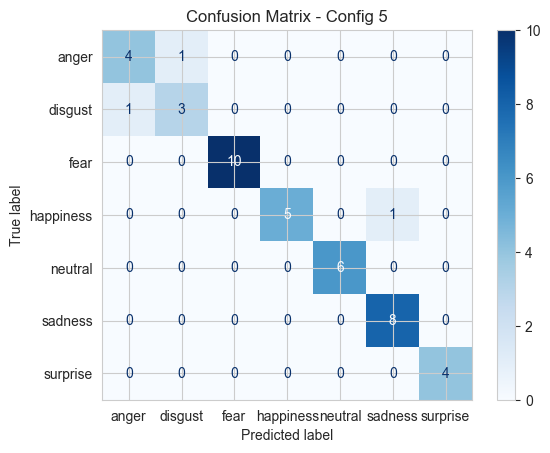

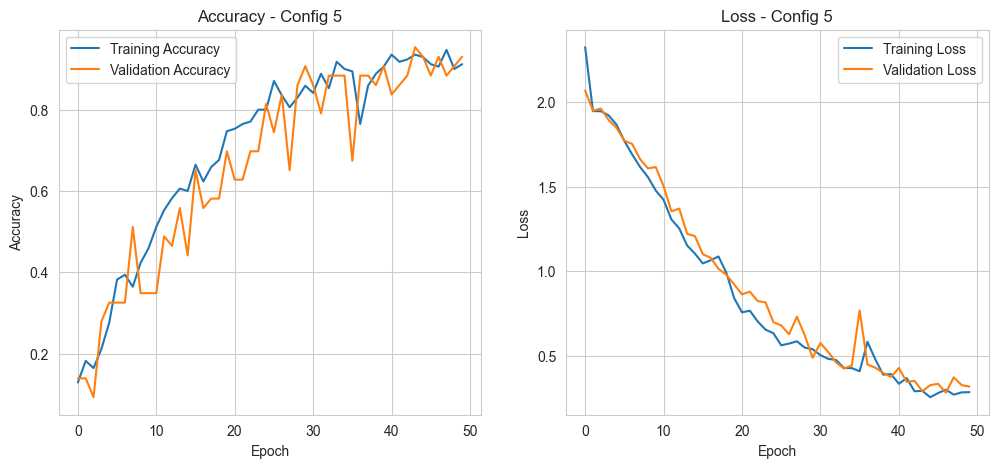


Top 6 Configuration: {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 256, 'dropout': 0.3, 'epochs': 50, 'batch_size': 8, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 93.02%
Precision: 0.97
Recall: 1.00
F1 Score: 0.99


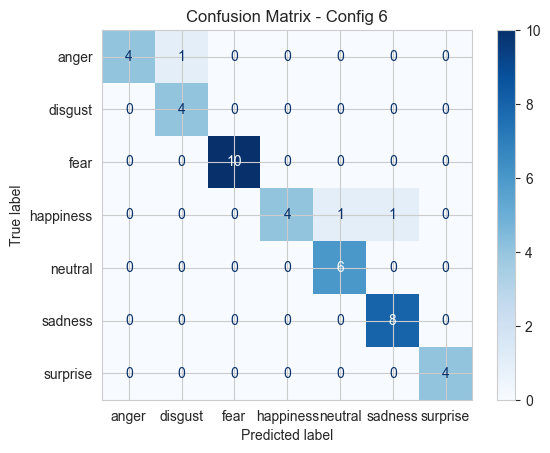

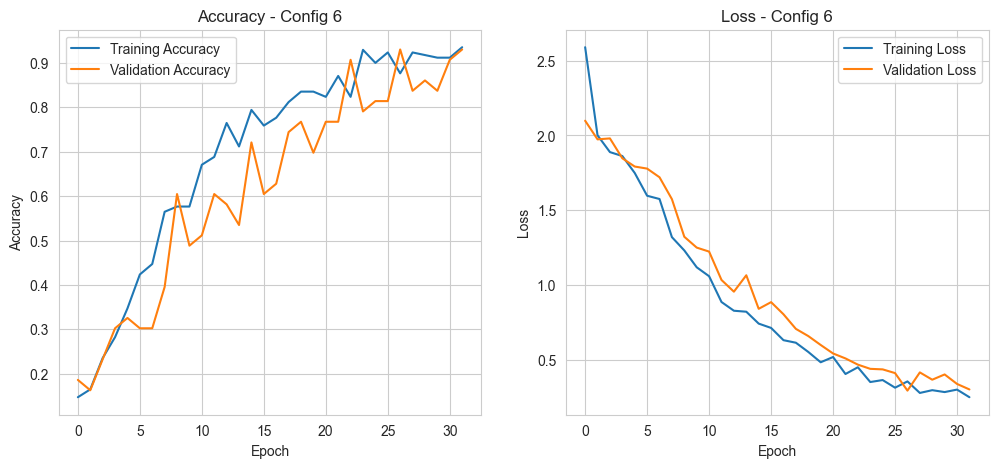


Top 7 Configuration: {'conv_layers': 1, 'filters': 64, 'dense_layers': 1, 'dense_units': 256, 'dropout': 0.3, 'epochs': 50, 'batch_size': 8, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 93.02%
Precision: 0.95
Recall: 1.00
F1 Score: 0.97


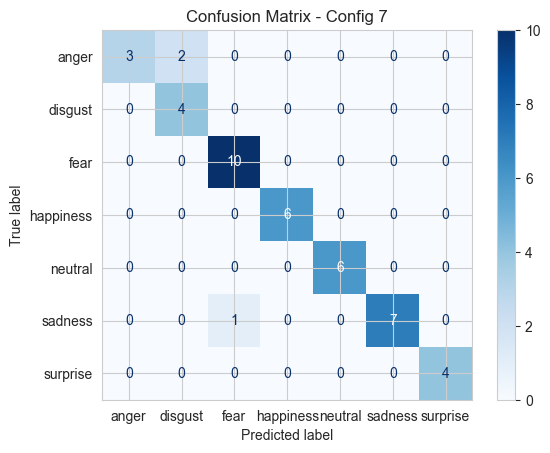

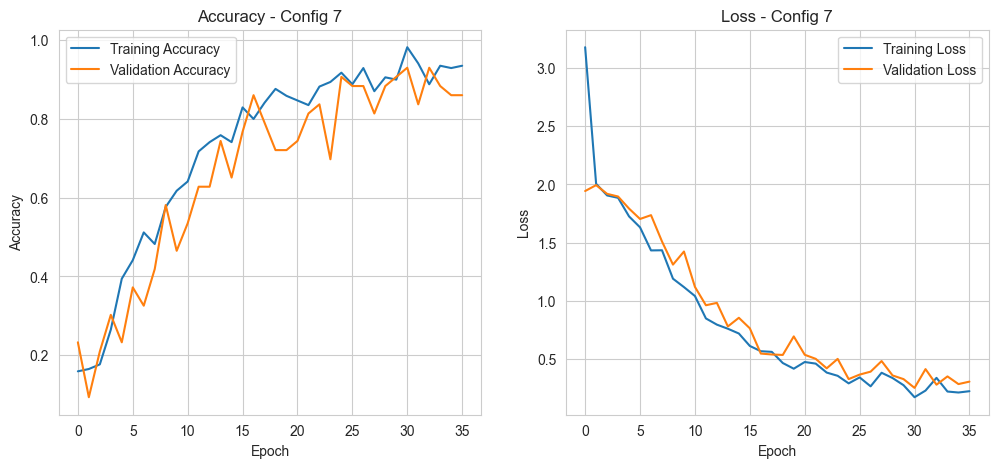


Top 8 Configuration: {'conv_layers': 1, 'filters': 64, 'dense_layers': 2, 'dense_units': 64, 'dropout': 0.3, 'epochs': 50, 'batch_size': 8, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 93.02%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97


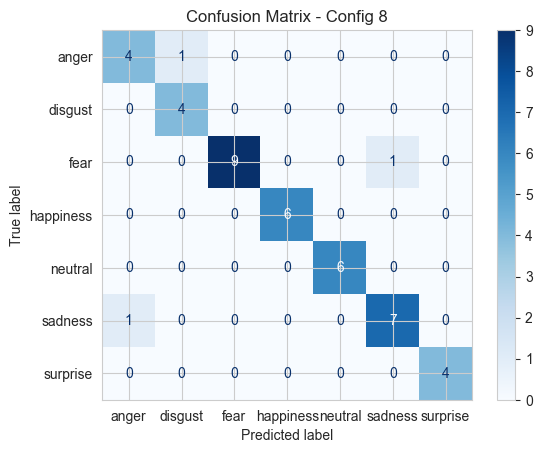

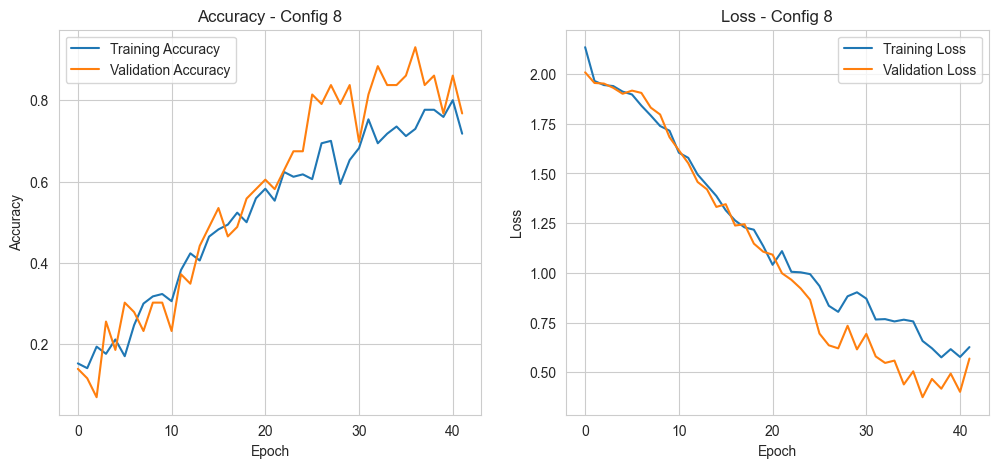


Top 9 Configuration: {'conv_layers': 1, 'filters': 64, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.3, 'epochs': 50, 'batch_size': 8, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 93.02%
Precision: 0.95
Recall: 1.00
F1 Score: 0.97


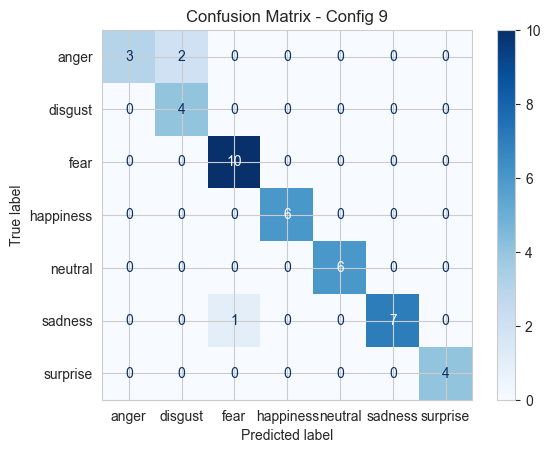

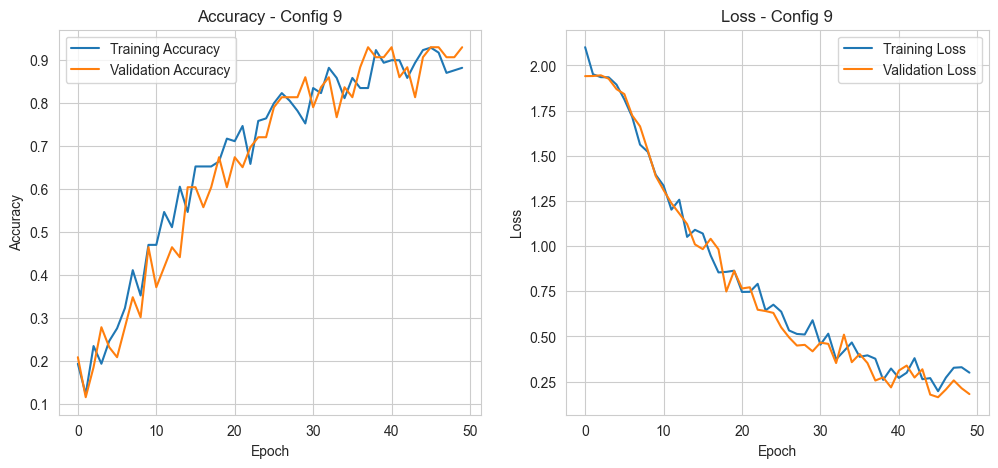


Top 10 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 256, 'dropout': 0.3, 'epochs': 50, 'batch_size': 16, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 93.02%
Precision: 1.00
Recall: 0.97
F1 Score: 0.99


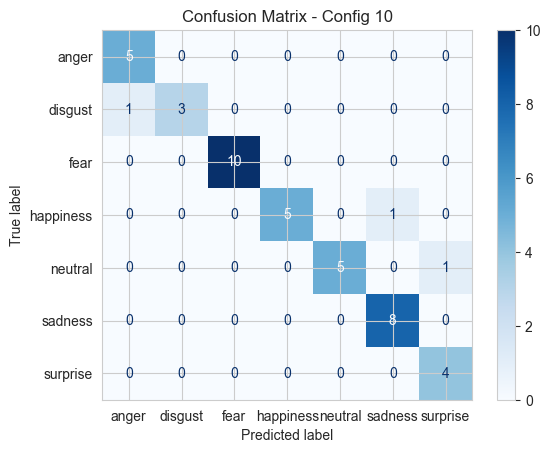

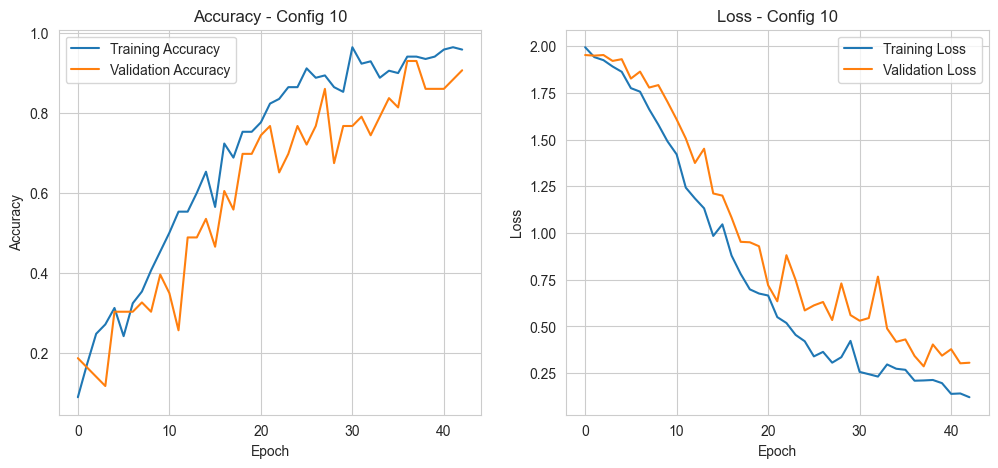


Top 11 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 2, 'dense_units': 256, 'dropout': 0.3, 'epochs': 50, 'batch_size': 16, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 93.02%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97


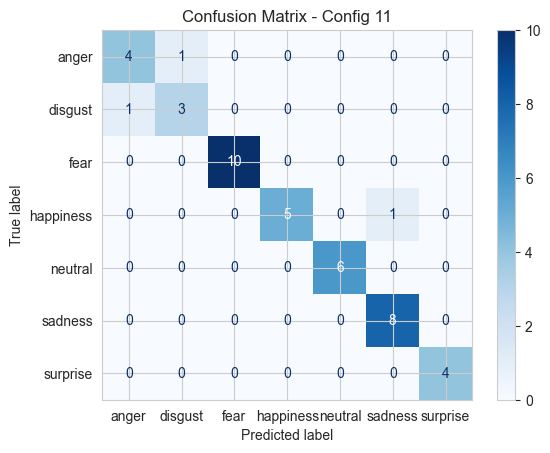

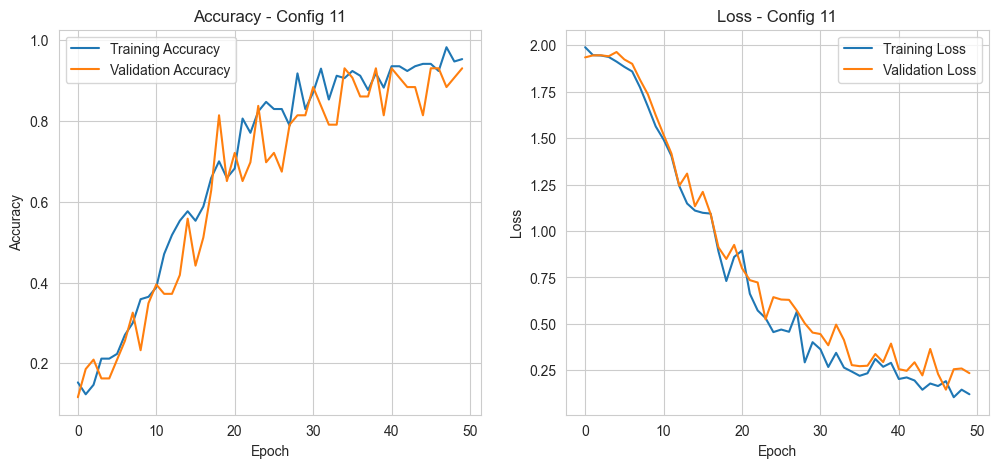


Top 12 Configuration: {'conv_layers': 1, 'filters': 32, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.3, 'epochs': 50, 'batch_size': 8, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 90.70%
Precision: 0.97
Recall: 1.00
F1 Score: 0.99


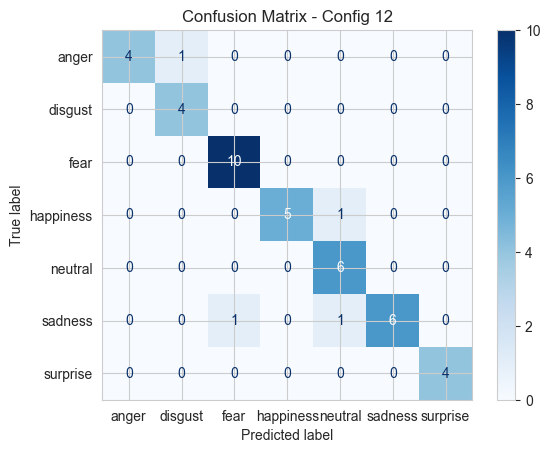

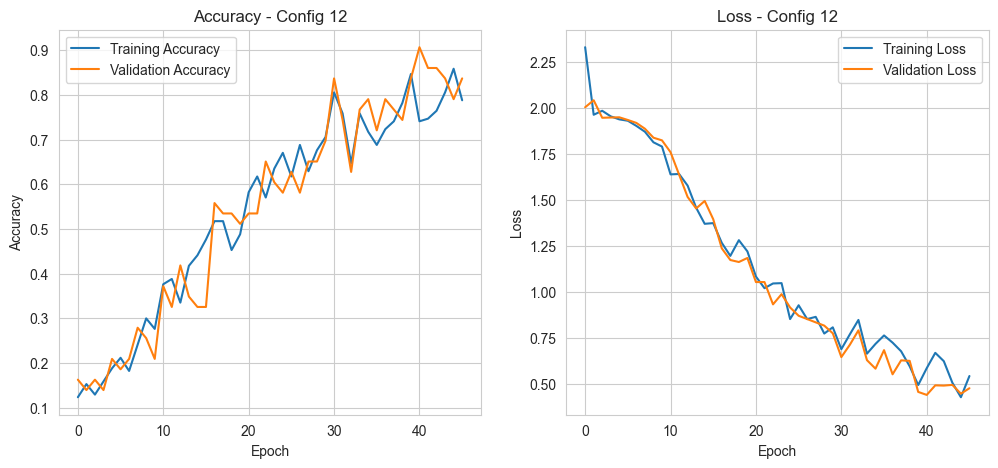


Top 13 Configuration: {'conv_layers': 1, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.3, 'epochs': 50, 'batch_size': 8, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 90.70%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97


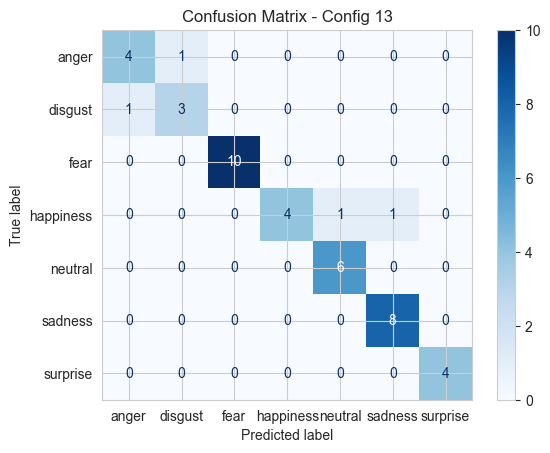

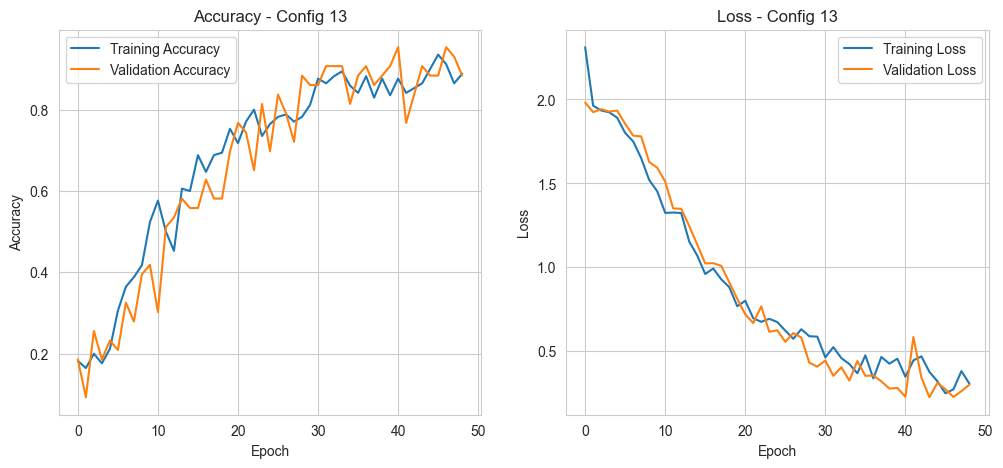


Top 14 Configuration: {'conv_layers': 1, 'filters': 64, 'dense_layers': 2, 'dense_units': 256, 'dropout': 0.3, 'epochs': 50, 'batch_size': 8, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 90.70%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97


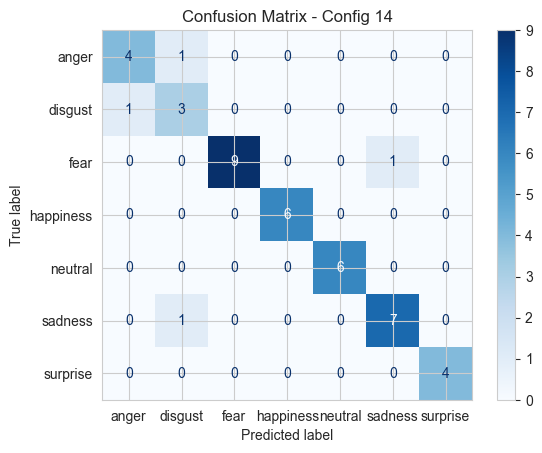

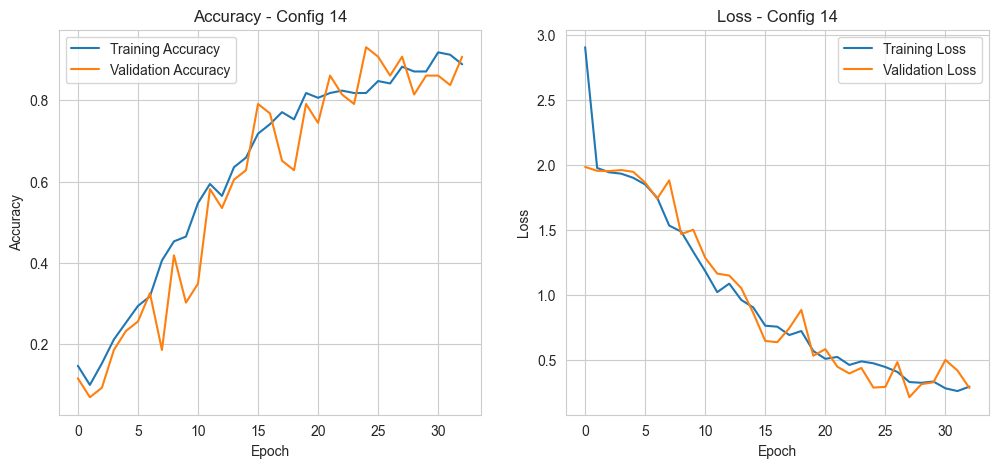


Top 15 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 256, 'dropout': 0.3, 'epochs': 50, 'batch_size': 8, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 90.70%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


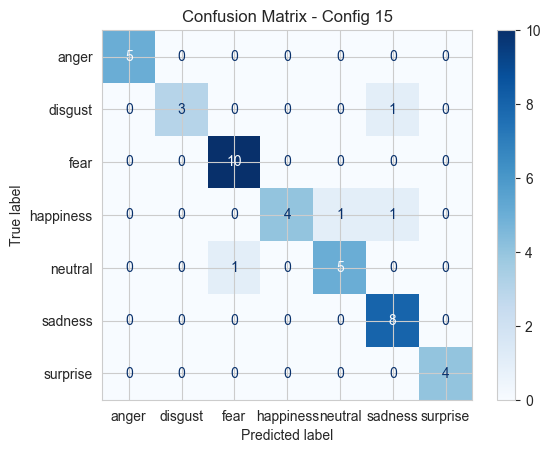

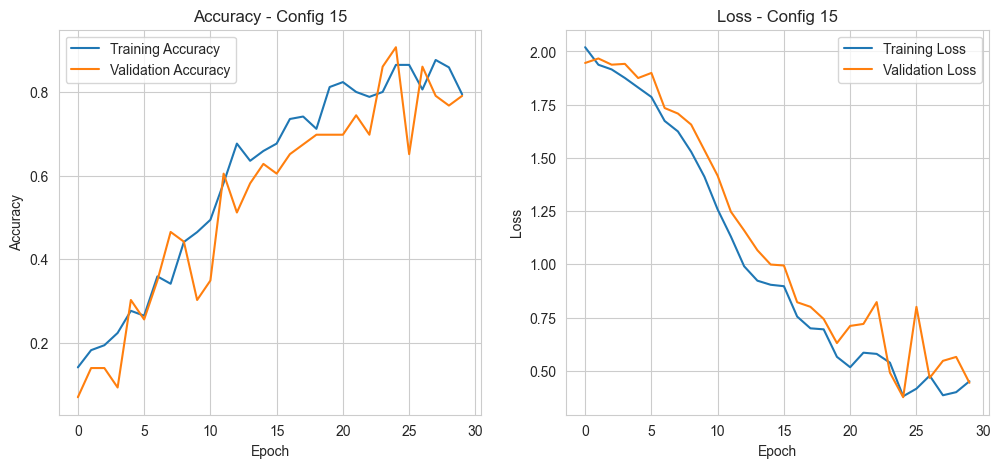


Summary of Top 15 Configurations:
Configuration 1: {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 256, 'dropout': 0.3, 'epochs': 50, 'batch_size': 16, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 97.67%
Precision: 0.97
Recall: 1.00
F1 Score: 0.99
Configuration 2: {'conv_layers': 1, 'filters': 32, 'dense_layers': 2, 'dense_units': 256, 'dropout': 0.3, 'epochs': 50, 'batch_size': 8, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 97.67%
Precision: 0.97
Recall: 1.00
F1 Score: 0.99
Configuration 3: {'conv_layers': 1, 'filters': 64, 'dense_layers': 1, 'dense_units': 256, 'dropout': 0.3, 'epochs': 50, 'batch_size': 16, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 95.35%
Precision: 1.00
Recall: 0.97
F1 Score: 0.99
Configuration 4: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.3, 'epochs': 50, 'batch_size': 16, 'learning_rate'

In [26]:
import itertools
import os
import random
import numpy as np
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
dataset_folder = r'C:/Users/user/Downloads/Thesis/linda_trials/JAFFE Dataset'

# Function to load images and extract labels
def load_images_and_labels(folder):
    images = []
    labels = []
    label_map = {
        "AN": "anger",
        "DI": "disgust",
        "FE": "fear",
        "HA": "happiness",
        "SA": "sadness",
        "SU": "surprise",
        "NE": "neutral"
    }

    for filename in os.listdir(folder):
        if filename.endswith('.tiff'):
            image_file = os.path.join(folder, filename)
            img = Image.open(image_file).convert('L')  # Convert to grayscale
            img = img.resize((64, 64))  # Resize to 64x64 for consistency
            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
            label_code = filename.split('.')[1][:2]
            labels.append(label_map[label_code])

    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Display a few sample images with their labels
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].reshape(64, 64), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
plt.show()

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)


# Define the CNN architecture function with variable parameters
def create_model(conv_layers, filters, dense_layers, dense_units, dropout, learning_rate, activation, optimizer):
    model = Sequential()
    model.add(InputLayer(input_shape=(64, 64, 1)))  # Input layer for 64x64 grayscale images

    # Add convolutional layers
    for _ in range(conv_layers):
        model.add(Conv2D(filters, kernel_size=(3, 3), activation=activation))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # Flatten the output for the dense layer

    # Add dense layers
    for _ in range(dense_layers):
        model.add(Dense(dense_units, activation=activation))
        model.add(Dropout(dropout))  # Add dropout to prevent overfitting

    # Output layer
    model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))

    # Compile model with the given optimizer and learning rate
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize list to store results
results = []

# Define parameter ranges for CNN architecture and training
# parameter_combinations = list(itertools.product(
#     [1],           # conv_layers: Try 1 or 2 convolutional layers.
#     [32, 64],         # filters: Use either 32 or 64 filters.
#     [1],              # dense_layers: Stick with 1 dense layer for simplicity.
#     [64, 128],        # dense_units: Test 64 or 128 units in the dense layer.
#     [0.2],            # dropout: Use a fixed dropout rate of 0.2.
#     [30, 50],         # epochs: Experiment with 30 or 50 epochs.
#     [16, 32],         # batch_size: Use a batch size of 16 or 32.
#     [0.001],          # learning_rate: Use a fixed learning rate of 0.001.
#     ['relu'],         # activation: Use ReLU activation.
#     ['adam']          # optimizer: Use the Adam optimizer.
# ))
# # Your previous code...
# parameter_combinations = list(itertools.product(
#     [1, 2],           # conv_layers: Try 1 or 2 convolutional layers.
#     [32, 64],         # filters: Use 32 or 64 filters.
#     [1],              # dense_layers: Stick with 1 dense layer for simplicity.
#     [32, 64, 128],    # dense_units: Test 32, 64, or 128 units in the dense layer.
#     [0.2, 0.3, 0.4],  # dropout: Test dropout rates of 0.2, 0.3, or 0.4.
#     [30, 50],         # epochs: Experiment with 30 or 50 epochs (with early stopping).
#     [16, 32],         # batch_size: Use batch sizes of 16 or 32.
#     [0.001, 0.0001],  # learning_rate: Test learning rates of 0.001 and 0.0001.
#     ['relu'],         # activation: Use ReLU activation.
#     ['adam', 'sgd']   # optimizer: Test Adam and SGD optimizers.
# ))

parameter_combinations = list(itertools.product(
    [1, 2],           # conv_layers: Focus on 1 or 2 convolutional layers.
    [32, 64],         # filters: Use 32 or 64 filters.
    [1,2],              # dense_layers: Stick with 1 dense layer for simplicity.
    [64, 128,256],        # dense_units: Test 64 or 128 units in the dense layer.
    [0.3],       # dropout: Focus on dropout rates of 0.2 and 0.3.
    [50],         # epochs: Experiment with 30 or 50 epochs.
    [8,16],         # batch_size: Use batch sizes of 16 or 32.
    [0.001],          # learning_rate: Focus on a learning rate of 0.001.
    ['relu'],         # activation: Use ReLU activation.
    ['adam']          # optimizer: Use Adam optimizer.
))




# Continue with your training and evaluation loop...


# Loop through each combination
for idx, (conv_layers, filters, dense_layers, dense_units, dropout, epochs, batch_size, learning_rate, activation, optimizer) in enumerate(parameter_combinations):
    config = {
        "conv_layers": conv_layers,
        "filters": filters,
        "dense_layers": dense_layers,
        "dense_units": dense_units,
        "dropout": dropout,
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "activation": activation,
        "optimizer": optimizer
    }

    print(f"Running configuration {idx+1}/{len(parameter_combinations)}: {config}")

    # Create the model
    model = create_model(conv_layers, filters, dense_layers, dense_units, dropout, learning_rate, activation, optimizer)

    # Define data augmentation configuration (if you want to include data augmentation, otherwise you can skip this)
    datagen = ImageDataGenerator(
        shear_range=0.0,
        zoom_range=0.1,
        rotation_range=0,
        width_shift_range=0.0,
        height_shift_range=0.0,
        horizontal_flip=False
    )

    # Fit the data generator to the training data
    datagen.fit(X_train)

    # Add early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model using the data generator
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size, seed=42),
        validation_data=(X_test, y_test),
        epochs=epochs,
        callbacks=[early_stopping],  # Add early stopping
        verbose=0  # Suppress epoch prints
    )

    # Evaluate the model and store the results
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    predictions = model.predict(X_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    precision = tf.keras.metrics.Precision()
    precision.update_state(true_classes, predicted_classes)
    recall = tf.keras.metrics.Recall()
    recall.update_state(true_classes, predicted_classes)
    f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

    # Store the configuration and results
    config_results = {
        'config': config,
        'test_accuracy': test_acc,
        'precision': precision.result().numpy(),
        'recall': recall.result().numpy(),
        'f1_score': f1_score,
        'history': history.history,
        'confusion_matrix': confusion_matrix(true_classes, predicted_classes),
        'labels': label_encoder.classes_
    }
    print(f"Configuration {idx+1}: {config_results['config']}")
    print(f"Test Accuracy: {config_results['test_accuracy']*100:.2f}%")
    print(f"Precision: {config_results['precision']:.2f}")
    print(f"Recall: {config_results['recall']:.2f}")
    print(f"F1 Score: {config_results['f1_score']:.2f}")
    print("="*50)

    results.append(config_results)

# Sort results by test accuracy and take the top 15
results_sorted = sorted(results, key=lambda x: x['test_accuracy'], reverse=True)[:15]

# Plot results for top 15 configurations
for i, result in enumerate(results_sorted):
    print(f"\nTop {i+1} Configuration: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=result['confusion_matrix'], display_labels=result['labels'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - Config {i+1}")
    plt.show()

    # Plot accuracy and loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(result['history']['accuracy'], label='Training Accuracy')
    plt.plot(result['history']['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy - Config {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(result['history']['loss'], label='Training Loss')
    plt.plot(result['history']['val_loss'], label='Validation Loss')
    plt.title(f'Loss - Config {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Summary of top 15 configurations
print("\nSummary of Top 15 Configurations:")
for i, result in enumerate(results_sorted):
    print(f"Configuration {i+1}: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")
    print("="*50)


The above code is an implementation of a hyperparameter search for a Convolutional Neural Network (CNN) on the JAFFE dataset, exploring various configurations to identify the best-performing model based on accuracy, precision, recall, and F1 score. Here's a breakdown of the process:

### **Dataset Preparation:**
- **Loading Images and Labels**: Images are loaded from the specified folder, converted to grayscale, resized to 64x64 pixels, and normalized. Labels are mapped from filename codes to emotions (e.g., "AN" for anger).
- **Data Splitting**: The dataset is split into training (80%) and testing (20%) sets.

### **CNN Model:**
- The CNN model architecture is flexible, allowing for different numbers of convolutional and dense layers, different filter sizes, units in dense layers, dropout rates, learning rates, and optimizers.
- **Model Architecture**:
1. **Input Layer**: Takes input of shape `(64, 64, 1)` for grayscale images.
    2. **Convolutional Layers**: The number and size of convolutional layers vary based on the parameters.
3. **MaxPooling Layers**: Pooling layers are added after each convolutional layer.
4. **Flatten Layer**: Converts the 2D feature maps to a 1D vector.
5. **Dense Layers**: The number and size of dense layers vary based on the parameters.
6. **Dropout**: Applied to prevent overfitting, with the rate controlled by the parameters.
7. **Output Layer**: Softmax activation with neurons equal to the number of emotion classes.

### **Parameter Search:**
- **Parameters Explored**:
- **Convolutional Layers**: 1 or 2.
- **Filters**: 32 or 64.
- **Dense Layers**: 1 or 2.
- **Dense Units**: 64, 128, or 256.
- **Dropout Rate**: 0.3.
- **Epochs**: 50.
- **Batch Size**: 8 or 16.
- **Learning Rate**: 0.001.
- **Activation Function**: ReLU.
- **Optimizer**: Adam.
- **Data Augmentation**: A minimal amount of augmentation is applied (zoom range of 0.1).

### **Training and Evaluation:**
- **Early Stopping**: Implemented to prevent overfitting, with monitoring on validation loss and a patience of 5 epochs.
- **Training**: The model is trained for up to 50 epochs with the specified batch size, but early stopping may halt training sooner.
- **Evaluation Metrics**:
- **Test Accuracy**: Percentage of correct predictions on the test set.
- **Precision, Recall, F1 Score**: Calculated to provide a detailed performance analysis.
- **Confusion Matrix**: Generated for each configuration to visualize classification performance.

### **Results Analysis:**
- **Top 15 Configurations**: The results are sorted by test accuracy, and the top 15 configurations are selected for further analysis.
    - **Visualization**:
- **Confusion Matrix**: Displayed for each top configuration using a heatmap.
- **Accuracy and Loss Plots**: Plots of training and validation accuracy/loss over epochs are displayed for each top configuration.
- **Summary**: A summary of the top 15 configurations, including their test accuracy, precision, recall, and F1 score, is printed.

### **Conclusion:**
This code systematically explores various CNN configurations and hyperparameters to identify the most effective model for emotion classification using the JAFFE dataset. The results are analyzed and visualized to determine the best-performing models based on the evaluation metrics.

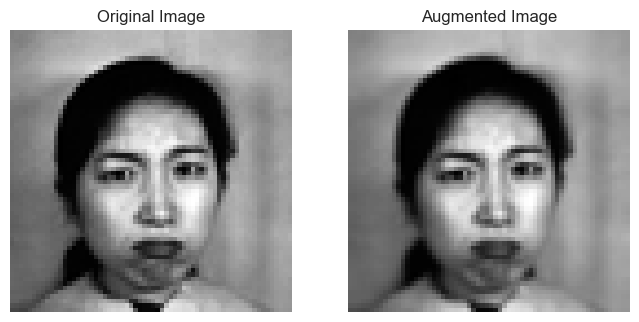

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Select an image from the training set
image_index = np.random.randint(len(X_train))  # Randomly select an index
original_image = X_train[image_index].reshape(1, 64, 64, 1)  # Reshape for data generator

# Define the data augmentation generator with the desired configuration
datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=0.1,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=False
)

# Generate an augmented image
augmented_iter = datagen.flow(original_image, batch_size=1)
augmented_image = next(augmented_iter)[0].reshape(64, 64)  # Get the augmented image and reshape it

# Plot the original and augmented images side by side
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(original_image.reshape(64, 64), cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Augmented Image
plt.subplot(1, 2, 2)
plt.imshow(augmented_image, cmap='gray')
plt.title('Augmented Image')
plt.axis('off')

plt.show()
